# Lagrangrian Variational Autoencoder (Draft)

Note: The code below is functional. However, the explanation here is still in draft form.

This is implemented with pytorch and lightning. The code is based on the [paper](https://arxiv.org/abs/1806.06514) and [tensorflow code](https://github.com/ermongroup/lagvae) by Ermon et al.

The most notable change from a basic VAE is that instead of directly optimizing the loss, they are optimizing the [Lagrangian dual problem](https://en.wikipedia.org/wiki/Duality_(optimization)#Dual_problem). A tutorial on convex optimization involving the Lagrangian dual problem can be found [here](http://eceweb.ucsd.edu/~gert/ECE273/hindiTutorial2.pdf). If you've taken vector calculus, you may have seen a form of the Lagrangian before as Lagrange multipliers. The idea is similar, but now more generally applicable.

The basic VAE gives us a process by which to find a probability distribution $p(x, z)$, where $x$ are observations and $z$ are latent variables. This is done by factoring $p(x, z)$ to $p(x|z)p(z)$. The distribution $p(z)$ is specified to be normal a priori, while $p(x|z) = p(x|z, \theta)$ is a parameterized distribution that is learned through the decoder. To make the process of finding $p(x)$ tractable, we introduce the variational distribution $q(z|x)$, which approximates $p(z|x)$. We can similarly define a distribution $q(x, z) = q(z|x)q(x)$. Ideally, the variational distribution $q(z|x) = p(z|x)$, and so we would like $p(x, z) = q(x, z)$. If the two joint distributions are equal, then their marginals will be equal.

This provides another way of training the model, which is to enforce consistency. The basic VAE is trained to maximize the evidence lower bound. As shown in the paper above, this is equivalent to the optimization problem

$$ \min_\theta \text{KL}(q(x, z | \theta) \Vert p(x, z | \theta))$$

where KL is the Kullback-Leibler divergence. Other variational autoencoders can be shown to be equivalent to minimization problems using different divergences. With this in mind, we let $\mathcal{D}$ be a vector of divergences between probabilities. We require that $\mathcal{D} = 0$ (so that $\mathcal{D}_i = 0$ for each $i$) if and only if $p(x, z) = q(x, z)$. This allows us to use $\mathcal{D}$ to enforce consistency. As this depends on the parameters for the distributions, we have that $\mathcal{D}$ depends on $\theta$, i.e. $\mathcal{D} = \mathcal{D}(\theta)$. I'll write the latter to emphasize the connection to theta.

However, having consistent marginals does not guarantee that there is any meaningful relationship between $x$ and $z$. The paper tackles this latter problem by using an extra function $f(\theta)$. The specific function that is chosen is based on our preferences between consistent distributions. The choice in the code below for $f$ is one that encodes a preference for mutual information. Our optimization problem has now become

$$\min_\theta f(\theta) \text{ where } \mathcal{D}(\theta) = 0.$$

This has the dual problem

$$\max_{\lambda \geq 0}\min_\theta \left[f(\theta)+\lambda^T\mathcal{D}(\theta)\right],$$

where $\theta$ includes choices where $\mathcal{D}(\theta) \geq 0$. This second equation comes from considering the convex conjugate of $f$. in the dual space, which gives rise to the name 'dual problem.' The important factor is that the same parameter $\theta$ is the solution for both equations when we have strong duality.

We do need to make a slight adjustment, however. We will not in practice have $\mathcal{D} = 0$ for all models as a result of having finite capacity. Instead, we choose a 'consistency constraint' vector $\epsilon$ that limits the size of $\mathcal{D}$. In this situation, we optimize

$$\min_\theta f(\theta) \text{ where } \mathcal{D}_i \leq \epsilon_i.$$

which has the corresponding dual equation

$$\max_{\lambda \geq 0}\min_\theta \left[f(\theta)+\lambda^T(\mathcal{D}-\epsilon)\right].$$

## Code
### Variational Encoder

In [37]:
import torch as t
import torch.nn as nn

In [38]:
class VariationalEncoder(nn.Module):
    '''
    Encodes an observation to the latent variable parameters.
    
    :param z_dim: (int) Dimension of latent variable
    '''
    def __init__(self, z_dim=64):
        super(VariationalEncoder, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(28**2, 1024),
            nn.Softplus(),
            nn.Linear(1024, 1024),
            nn.Softplus()
        )
        self.mean = nn.Linear(1024, z_dim)
        self.logscale = nn.Linear(1024, z_dim)

    def forward(self, input):
        input = input.flatten(1)
        x = self.network(input)
        
        mean = self.mean(x)
        logscale = self.logscale(x)
        scale = logscale.exp()
        return mean, scale

### Variational Decoder

In [39]:
class VariationalDecoder(nn.Module):
    '''
    Decodes the latent variable to an observation.
    
    :param z_dim: (int) Dimension of latent variable
    '''
    def __init__(self, z_dim=64):
        super(VariationalDecoder, self).__init__()
        self.z_dim = z_dim
        self.network = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.Softplus(),
            nn.Linear(1024, 1024),
            nn.Softplus(),
            nn.Linear(1024, 28**2)
        )

    def forward(self, z):
        x = self.network(z)
        return x.view((-1,1,28,28))

### Lagrangian Variational Autoencoder

In [40]:
class LagrangianVAE(nn.Module):
    '''
    Implements a Lagrangian VAE. This differs from a other VAEs as it is optimized
    according to a dual optimization problem.
    
    :param encoder: (nn.Module) Encoder network. Should return mean, scale.
    :param decoder: (nn.Module) Decoder network. Should return the observation reconstruction.
    :param mi: (float) Mutual information parameter. A positive value places emphasis on
        mutual information under p(x, z). A negative value emphasizes mutual information
        under q(x, z).
        
        More directly, a positive value emphasizes the reconstruction error while a negative
        value emphasizes the latent error.
    :param e: ((float)) Relaxed consistency constraint. This is used to make the optimization
        problem tractible.
    :param lmbda: ((float)) Starting value for lambda.
    :param mmd_scale: (float) How much to scale the maximum mean discrepency.
    :param optimize_lambda: (Bool) Whether lambda will be optimized over. Setting to False
        will fix lambda at its starting value.
    '''
    def __init__(self,  
                 encoder, 
                 decoder, 
                 mi, 
                 e = (1., 1.), 
                 lmbda = (1., 1.), 
                 mmd_scale=10000.,
                 optimize_lambda=True):
        super(LagrangianVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        #The feasability parameter. (See section 5.2 in the paper)
        self.e1 = e[0]
        self.e2 = e[1]
        #Mutual information parameter
        self.mi = mi
        #How much to scale the maximum mean divergence. They use 10k in the code
        self.mmd_scale = mmd_scale
        #Should we optimize lambda? If false, lambda stays fixed.
        #If lambda is fixed, this is not exactly a LagVAE, but it impliments other things.
        self.optimize_lambda = optimize_lambda
        
        self.lambda_1 = nn.Parameter(t.Tensor((1)))
        nn.init.constant_(self.lambda_1, lmbda[0])
        self.lambda_2 = nn.Parameter(t.Tensor((1)))
        nn.init.constant_(self.lambda_2, lmbda[1])

    def forward(self, input):
        mean, scale = self.encoder(input)
        
        eps = t.randn_like(mean)
        z = mean+eps*scale
        
        x = self.decoder(z)
        
        #reconstruction error - this is the negative logpxz
        nlogpxz = F.binary_cross_entropy_with_logits(x, input, reduction='none').sum([1,2,3])
        nll = nlogpxz.mean(0)

        #latent error
        mmd = self.compute_mmd(z)*self.mmd_scale #they scale by 10000
        elbo = self.elbo(z, eps, scale).mean()

        #save written space
        L1 = self.lambda_1
        L2 = self.lambda_2

        if self.mi <= 0:
            loss = L1*nll + (L1-self.mi)*elbo + L2*mmd - L1*self.e1 - L2*self.e2
        else:
            loss = (L1+self.mi)*nll + L1*elbo + L2*mmd - L1*self.e1 - L2*self.e2

        #Record losses
        loss_dict = {
            'loss': loss,
            'nll': nll,
            'elbo': elbo,
            'mmd': mmd
        }
        return x, loss_dict
    
    def generate_similar(self, input, noise=True):
        '''
        Generates similar images to input.
        
        :param input: (t.Tensor) Original observation
        :param noise: (Bool) Whether to inject noise into the reconstruction.
            By default, z = N(mu, Sigma). If noise is False, then z = mu.
        '''
        mean, scale = self.encoder(input)
        if noise:
            eps = t.randn_like(mean)
            z = mean+eps*scale
        else:
            z = mean
        return self.decoder(z)
    
    @staticmethod
    def compute_mmd(z):
        '''
        Compute maximum mean discrepency for the latent variable z.
        
        :param z: (t.Tensor)
        :return: (t.Tensor) 
        '''
        true_sample = t.randn_like(z)
        return compute_mmd(z, true_sample)
    
    def child_parameters(self):
        '''
        Construct generator that returns all parameters but lambda.
        '''
        #Return all parameters but the lambda parameters.
        for name, parameter in self.named_parameters(recurse=True):
            if name in ['lambda_1', 'lambda_2']:
                pass
            else:
                yield parameter
    
    @staticmethod
    def elbo(z, eps, scale):
        '''
        Compute ELBO loss for the encoding.
        
        :param z: (t.Tensor) Latent variable
        :param eps: (t.Tensor) Noise used to generate z. Should have
            eps ~ N(0, I). 
        :param scale: (t.Tensor) Scale used to generate z.
        :return: (t.Tensor) evidence lower bound.
        '''
        return t.sum(z.pow(2)/2-eps.pow(2)/2-scale.log(), 1)

In [41]:
#Computes maximal mean divergence (mmd)
def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return t.exp(-kernel_input) # (x_size, y_size)

## Setting up the experiment in Lightning

### Solving a max-min problem
The most notable change from a basic VAE is that instead of directly optimizing the loss, we are attempting to solve the Lagrangian dual problem. While we are attempting to minimize the objective with respect to $\theta$, we are trying to maximize it with respect to $\lambda$. The issue that this causes is that the optimizers in pytorch are designed to minimize only. It turns out there is an easy fix, though: after calling backwards, change the stored gradient to be negative. (Linearity of differentation is great for a lot of reasons.) Alternatively, you can use `(-loss).backward(retain_graph=True)`. As pytorch graphs are dynamic, we need to explicitely retain the graph. The reason I didn't use this is that it requires us to zero the gradients and call `loss.backward()` again to update the other parameters. 

We can use one optimizer for both sets of parameters if we take care to update the gradient first. We use an optimizer for each as in the original code, as it allows for greater control over our parameter updates.

In [42]:
from torch.nn import functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pytorch_lightning as pl

In [43]:
class VAE_template(pl.LightningModule):

    def __init__(self, model, dataset='MNIST', batch_size=128):
        super(VAE_template, self).__init__()
        self.net = model

        self.dataset = dataset.lower()
        self.batch_size = batch_size
        
        if self.net.optimize_lambda:
            self.lambda_optim = t.optim.RMSprop(self.net.parameters(recurse=False), lr=0.0001)
        else:
            self.lambda_optim = None

    def forward(self, x):
        return self.net.forward(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        x_hat, loss_dict = self.forward(x)
        
        loss = loss_dict.pop('loss')
        return {'loss': loss, 'prog': loss_dict}

    def validation_step(self, batch, batch_nb):
        # Finds the vae loss (neg log likelihood + evidence lower bound)
        x, y = batch
        x_hat, loss_dict = self.forward(x)

        return {'vae_loss': loss_dict['nll']+loss_dict['elbo']}

    def validation_end(self, outputs):
        # OPTIONAL
        avg_loss = t.stack([x['vae_loss'] for x in outputs]).mean()
        lambda_1 = self.net.lambda_1.item()
        lambda_2 = self.net.lambda_2.item()
        return {'avg_vae': avg_loss, 'lambda_1': lambda_1, 'lambda_2': lambda_2}

    def configure_optimizers(self):
        # Same optimizer used in tf implementation
        return t.optim.Adam(self.net.child_parameters(), betas=(.5, .999), lr=1e-4)

    @pl.data_loader
    def tng_dataloader(self):
        #Set up training data. We use the first 50k for training.
        tnfms = transforms.ToTensor()
        if self.dataset == 'mnist':
            dset = datasets.MNIST(root='./', train=True, download=True, transform=tnfms)
        elif self.dataset == 'fashion':
            dset = datasets.FashionMNIST(root='./', train=True, download=True, transform=tnfms)
        elif self.dataset == 'cifar':
            dset = datasets.CIFAR10(root='./', train=True, download=True, transform=tnfms)
        else:
            raise ValueError('Dataset not recognized')
        training_set = data.Subset(dset, range(50000))
        return data.DataLoader(training_set, batch_size=self.batch_size, num_workers=4)

    @pl.data_loader
    def val_dataloader(self):
        #Set up validation data. We use the last 10k for training. These are never optimized over.
        if self.dataset == 'mnist':
            dset = datasets.MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
        elif self.dataset == 'fashion':
            dset = datasets.FashionMNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
        elif self.dataset == 'cifar':
            dset = datasets.CIFAR10(root='./', train=True, download=True, transform=transforms.ToTensor())
        else:
            raise ValueError('Dataset not recognized')

        testing_set = data.Subset(dset, range(50000+1,60000))
        return data.DataLoader(testing_set, batch_size=self.batch_size)
        
    def on_batch_end(self):
        #Clamp lambda so that they are constrained. This is done in
        #place so that they can update during later iterations.
        #Can't clamp while grads are allowed, so disable for a moment.
        with t.no_grad():
            self.net.lambda_1.clamp_(0.001, 100)
            self.net.lambda_2.clamp_(0.001, 100)
            
    def optimizer_step(self, current_epoch, batch_nb, optimizer, optimizer_i):
        if self.net.optimize_lambda:
            #If we are optimizing with lambda, we switch the signs of the
            #derivatives to simulate differentiating -loss.
            self.net.lambda_1.grad *= -1
            self.net.lambda_2.grad *= -1
            self.lambda_optim.step()
        optimizer.step()
        optimizer.zero_grad()

### Training

In [44]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [45]:
#Save best model based on average vae loss. (nll+elbo)
checkpoint_callback = ModelCheckpoint(
    filepath='./models/lagvae',
    save_best_only=True,
    verbose=True,
    monitor='avg_vae',
    mode='min',
)

#Set up early stopping. Stops if the average vae loss does not improve after a number
#of epochs.
early_stopping = EarlyStopping(monitor='avg_vae', patience=2, mode='min')

In [46]:
def make_lagVAE(z_size, mi, e, lmbda = (1., 1.), mmd_scale=10000., optimize_lambda=True):
    encoder = VariationalEncoder(z_size)
    decoder = VariationalDecoder(z_size)
    return LagrangianVAE(encoder, decoder, mi, e, lmbda, mmd_scale, optimize_lambda)

## Choosing model parameters

If $\lambda$ is fixed, then we are no longer solving the dual problem. However, fixed choices of $\lambda$ can correspond to other VAEs. In the code above, we can disable optimizating $\lambda$. This effectively makes $\lambda$ a hyperparameter that must be chosen by the user, and turns the Lagrangian VAE into an InfoVAE. However, the InfoVAE does not guarantee that our solution will be consistent according to our choice of $\epsilon$. The benefit of the Lagrangian VAE is that by optimizing $\lambda$, we enforce the constraints. If we have $\mathcal{D}_i > \epsilon_i$, then $\lambda_i$ will grow increasingly positive until the constraint is satisfied. This forces the optimization problem to weigh the violation of the consistency more heavily.

The paper goes into detail about how a number of previous VAE models can be recovered by specific choices of parameters.

In [47]:
use_lagvae = True
e = (86., 5.)
mi = 1
lmbda = (1., 1.)
z_dim = 64

dataset = 'mnist'
lagVAE = make_lagVAE(z_dim, mi, e, lmbda, optimize_lambda=use_lagvae)

In [48]:
model = VAE_template(lagVAE, dataset, batch_size=1000)

trainer = Trainer(gpus=[0],
                  max_nb_epochs=300,
                  checkpoint_callback=checkpoint_callback)

trainer.fit(model)
t.save(model.state_dict(), './models/lagvae.pkl')

gpu available: True, used: True
VISIBLE GPUS: 0
                     Name                Type   Params
0                     net       LagrangianVAE  3904402
1             net.encoder  VariationalEncoder  1984640
2     net.encoder.network          Sequential  1853440
3   net.encoder.network.0              Linear   803840
4   net.encoder.network.1            Softplus        0
5   net.encoder.network.2              Linear  1049600
6   net.encoder.network.3            Softplus        0
7        net.encoder.mean              Linear    65600
8    net.encoder.logscale              Linear    65600
9             net.decoder  VariationalDecoder  1919760
10    net.decoder.network          Sequential  1919760
11  net.decoder.network.0              Linear    66560
12  net.decoder.network.1            Softplus        0
13  net.decoder.network.2              Linear  1049600
14  net.decoder.network.3            Softplus        0
15  net.decoder.network.4              Linear   803600
model and trainer

100%|█| 60/60 [00:07<00:00,  9.52it/s, avg_vae=103, batch_nb=49, elbo=25.2, epoch=294, gpu=0, lambda_1=2.2, lambda_2=0.177, loss=110.356, mmd=0.992, nll=79.7]

save callback...

Epoch 00295: avg_vae did not improve


100%|█| 60/60 [00:07<00:00,  9.43it/s, avg_vae=102, batch_nb=49, elbo=25.1, epoch=295, gpu=0, lambda_1=2.21, lambda_2=0.172, loss=110.269, mmd=0.619, nll=79.7]

save callback...

Epoch 00296: avg_vae improved from 102.47857 to 102.39942, saving model to ./models/lagvae/_ckpt_epoch_296.ckpt


100%|█| 60/60 [00:07<00:00,  9.55it/s, avg_vae=103, batch_nb=49, elbo=25.1, epoch=296, gpu=0, lambda_1=2.21, lambda_2=0.169, loss=110.222, mmd=0.89, nll=79.8] 

save callback...

Epoch 00297: avg_vae did not improve


100%|█| 60/60 [00:07<00:00,  9.45it/s, avg_vae=102, batch_nb=49, elbo=25.1, epoch=297, gpu=0, lambda_1=2.22, lambda_2=0.165, loss=110.327, mmd=1.02, nll=79.6] 

save callback...

Epoch 00298: avg_vae improved from 102.39942 to 102.30341, saving model to ./models/lagvae/_ckpt_epoch_298.ckpt


100%|█| 60/60 [00:07<00:00,  9.41it/s, avg_vae=102, batch_nb=49, elbo=25.2, epoch=298, gpu=0, lambda_1=2.22, lambda_2=0.162, loss=110.329, mmd=0.887, nll=79.5]

save callback...

Epoch 00299: avg_vae did not improve


100%|█| 60/60 [00:07<00:00,  9.20it/s, avg_vae=102, batch_nb=49, elbo=25.1, epoch=299, gpu=0, lambda_1=2.23, lambda_2=0.159, loss=110.264, mmd=0.894, nll=79.7]

save callback...

Epoch 00300: avg_vae did not improve


## Examples

### Reconstruction of images
Below are image reconstructions, similar to my [VAE notebook](./basic_VAE.ipynb). A notable difference though is that these images are much sharper. The noisy reconstructions also have greater consistency.

In [49]:
import matplotlib.pylab as plt
import numpy as np

image_dir = './images/'
image_desc = 'lagvae.png'
title_desc = 'with LagrangianVAE'

def image_plot(axis, image, **kwargs):
    axis.imshow(image.view(28,28), cmap='Greys', **kwargs)

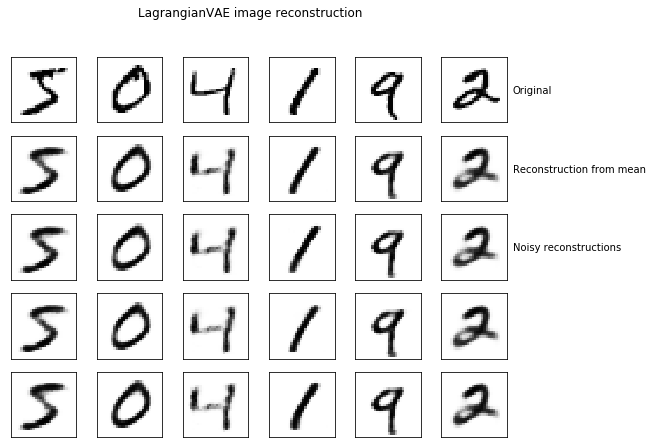

In [50]:
#Set up picture
ax_settings = {'aspect':'equal', 'xticklabels':[], 'yticklabels':[], 'xticks':[], 'yticks':[]}
fig, ax = plt.subplots(5, 6, subplot_kw=ax_settings, figsize=(9, 7))
if dataset.lower() == 'mnist':
    dset = datasets.MNIST(root='./', train=True, download=False, transform=transforms.ToTensor())
elif dataset.lower() == 'fashion':
    dset = datasets.FashionMNIST(root='./', train=True, download=False, transform=transforms.ToTensor())
loader = data.DataLoader(dset, batch_size=6, shuffle=False)
image_sample, _ = next(iter(loader))


lagVAE.cpu()
lagVAE.eval()
with t.no_grad():
    recons = lagVAE.generate_similar(image_sample, noise=False)
    for idx in range(6):
        image_plot(ax[0, idx], image_sample[idx,:])
        image_plot(ax[1, idx], t.sigmoid(recons[idx,:]))
        
    #Create similar examples with noise
    for row in range(2, 5):
        recons = lagVAE.generate_similar(image_sample)
        for idx in range(6):
            image_plot(ax[row, idx], t.sigmoid(recons[idx,:]))
            
fig.suptitle('LagrangianVAE image reconstruction')
plt.savefig('./images/lagvae-recon.png')
ax[0,-1].text(30, 15, 'Original')
ax[1,-1].text(30, 15, 'Reconstruction from mean')
ax[2,-1].text(30, 15, 'Noisy reconstructions')
plt.savefig('./images/MNIST-lagVAE-reconstructions.png', bbox_inches='tight')

### Reconstructions using sampling

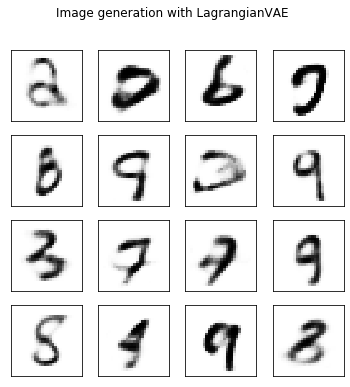

In [51]:
fig, axes = plt.subplots(4, 4, subplot_kw=ax_settings, figsize=(6, 6))
with t.no_grad():
    for ax_row in axes:
        for ax in ax_row:
            latent_sample = t.randn(1, z_dim)
            out = lagVAE.decoder(latent_sample)
            image_plot(ax, t.sigmoid(out[0]))
        
fig.suptitle('Image generation with LagrangianVAE')
plt.savefig('./images/MNIST-lagVAE-latent_samples.png')

### Distribution of means

Below we use Linear Discriminant Analysis as a dimension reduction tool to see the distribution of means. The image below shows us the result of the encodings on validation examples.

In [52]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

In [53]:
legend_label = model.val_dataloader.dataset.dataset.classes

model.eval()
with t.no_grad():
    means = []
    labels = []
    for image, label in model.val_dataloader:
        mean, _ = lagVAE.encoder(image)
        means.append(mean)
        labels.append(label)
    means = t.cat(means)
    labels = t.cat(labels)
    lda.fit(means, labels)
    X_embed = lda.transform(means)

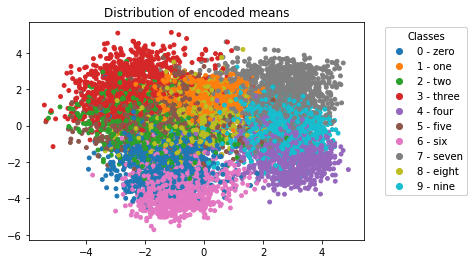

In [54]:
fig, ax = plt.subplots(1, 1)
class_labels = model.val_dataloader.dataset.dataset.classes
scatter = ax.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=15, cmap='tab10')
handles, _ = scatter.legend_elements()
legend1 = ax.legend(handles, class_labels, bbox_to_anchor=(1.05, 1), title="Classes")
ax.add_artist(legend1)

plt.title('Distribution of encoded means')
plt.savefig('./images/lagVAE-mean-distribution.png', bbox_inches='tight')